# Shot Boundery Detection by VGG16 vetcor Cloustering

In [37]:
import os

import multiprocessing
from joblib import Parallel, delayed

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
from progressbar import progressbar

def show(img, figsize=(5,5)):
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.show()

In [2]:
import itertools
import numpy as np
import pandas as pd
import networkx as nx

from natsort import natsorted, ns
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

import community

In [3]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import numpy as np

Using TensorFlow backend.


In [4]:
model = VGG16(weights='imagenet', include_top=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

## Predict for all images

In [5]:
"""if u are using GPU"""
gpu = True
if(gpu): num_cores = 1
else:    num_cores = multiprocessing.cpu_count()

In [6]:
# define model
model_vgg16 = model

# define input
filenames = os.listdir('./data/')[::1]

# define prediction function
def vgg16Pred(fname):
    try:
        img = image.load_img('data/'+fname, target_size=(224, 224))
        img_data = image.img_to_array(img)
        img_data = np.expand_dims(img_data, axis=0)

        vgg16_feature = model_vgg16.predict(img_data)
        vgg16_feature_np = np.array(vgg16_feature)

        return vgg16_feature_np.flatten()
    except: pass
    
vgg16_feature_list = Parallel(n_jobs=num_cores)(delayed(vgg16Pred)(fname) for fname in progressbar(filenames))
vgg16_feature_list_np = np.array(vgg16_feature_list)
vgg16_feature_list_np.shape

100% (275 of 275) |######################| Elapsed Time: 0:00:09 Time:  0:00:09


(275, 25088)

## Vec 2 Graph

In [18]:
A =  vgg16_feature_list_np
A_sparse = sparse.csr_matrix(A)

similarities = cosine_similarity(A_sparse)

In [19]:
G = nx.Graph()

fsize = len(filenames)
for i in progressbar(range(fsize-1)):
    for j in range(i, fsize):
        u,v = filenames[i], filenames[j]
        G.add_edge(u, v, weight = similarities[i][j] ) 


100% (274 of 274) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


In [20]:
# Get best partition
partition = community.best_partition(G)
print('Modularity: ', community.modularity(partition, G))

Modularity:  0.24363134751105844


In [51]:
# Keep only communities with a minimum of authors
centers = {}
communities = {}
G_main_com = G.copy()
min_nb = 1

topics = dict()

for com in set(partition.values()):
    list_nodes = np.array([nodes for nodes in partition.keys() if partition[nodes] == com])
    if len(list_nodes) < min_nb:
        G_main_com.remove_nodes_from(list_nodes)
    else:
        # Get center
        H = G_main_com.subgraph(list_nodes)
        d_c = nx.degree_centrality(H)
        center = max(d_c, key=d_c.get)
        centers[center] = com
        communities[com] = center
        
        #Get Topcs
        topics[center] = list_nodes
topics

{'image_1232.jpg': array(['image_1496.jpg', 'image_671.jpg', 'image_897.jpg',
        'image_649.jpg', 'image_1495.jpg', 'image_1529.jpg',
        'image_1127.jpg', 'image_616.jpg', 'image_154.jpg',
        'image_1133.jpg', 'image_1012.jpg', 'image_1243.jpg',
        'image_352.jpg', 'image_345.jpg', 'image_138.jpg',
        'image_1232.jpg', 'image_132.jpg', 'image_1551.jpg',
        'image_1122.jpg', 'image_627.jpg', 'image_414.jpg',
        'image_396.jpg', 'image_99.jpg', 'image_1540.jpg', 'image_341.jpg',
        'image_121.jpg', 'image_1485.jpg', 'image_55.jpg', 'image_781.jpg',
        'image_638.jpg', 'image_407.jpg', 'image_110.jpg', 'image_92.jpg',
        'image_1364.jpg', 'image_363.jpg', 'image_143.jpg',
        'image_935.jpg', 'image_1155.jpg', 'image_770.jpg',
        'image_667.jpg', 'image_1023.jpg', 'image_418.jpg',
        'image_1357.jpg', 'image_1507.jpg', 'image_1276.jpg',
        'image_1541.jpg', 'image_621.jpg', 'image_69.jpg', 'image_902.jpg',
        'image

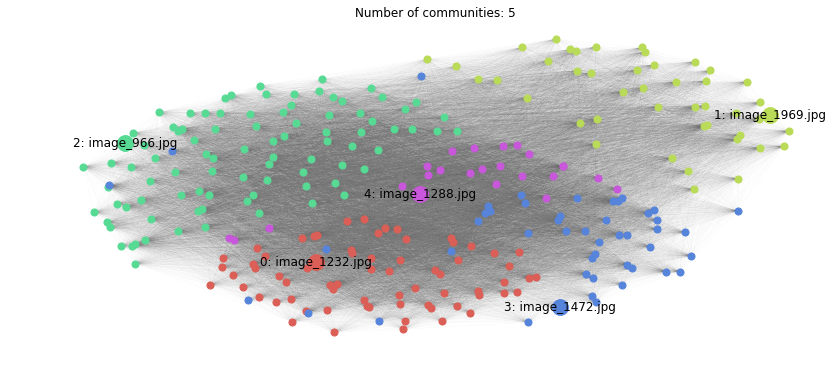

In [52]:
# Display graph
plt.figure(figsize=(14, 6))
node_size = 50
count = 0
pos = nx.spring_layout(G)
colors = dict(zip(communities.keys(), sns.color_palette('hls', len(communities.keys()))))

for com in communities.keys():
    count = count + 1
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com and nodes not in communities.values()]
    nx.draw_networkx_nodes(G_main_com, pos, list_nodes, node_size = node_size, node_color = colors[com])
    nx.draw_networkx_nodes(G_main_com, pos, list([communities[com]]), node_size = node_size*5, node_color = colors[com])
nx.draw_networkx_edges(G_main_com, pos, alpha=0.01)
labels = {k: str(v) + ': ' + k for k,v in centers.items()}
nx.draw_networkx_labels(G_main_com, pos, labels)

plt.title("Number of communities: "+str(len(topics)))
plt.axis('off')
plt.show()

## Main Scenes

[#image_1232.jpg size=68]//////////////////////////// 

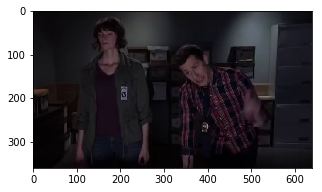


[#image_1969.jpg size=45]//////////////////////////// 

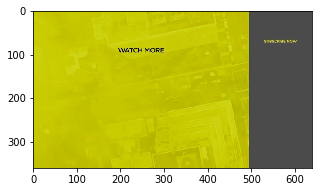


[#image_966.jpg size=90]//////////////////////////// 

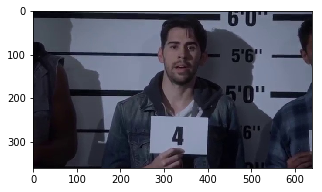


[#image_1472.jpg size=48]//////////////////////////// 

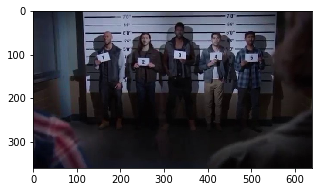


[#image_1288.jpg size=24]//////////////////////////// 

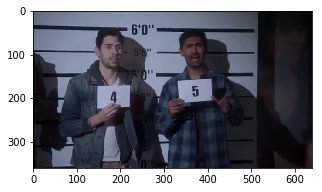

In [53]:
for label in topics:
    print('[#'+str(label), "size="+str(len(topics[label])), end="]//////////////////////////// ")
    classNumber = label
    show(image.load_img('./data/'+classNumber))

    print()